# File for working on and testing implementation of UNSGAIII into JMetalPy
## Based on *A Unified Evolutionary Optimization Procedure for Single, Multiple, and Many Objectives* by Seada et al.
https://ieeexplore.ieee.org/abstract/document/7164289?casa_token=2ymjPNx8H4MAAAAA:av11CNekEUwe6PROlnY2D7k2iO7GrKTUAe9scEE_TdZ8mt0J4oZVr9JUvoq-TBBEZ-LMLZrH


Original NSGAIII algorithm |     UNSGAIII Niching     |  Insertion of UNSGAIII Niching
:-------------------------:|:-------------------------|:-------------------------:
![](imgs/NSGAIII.png)      |![](imgs/UNSGAIII_niching.png)| ![](imgs/UNSGAIII_adding.png)

In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
from JMetalPy_modified import *
import copy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [3]:
rauniyar_constants_light_vehicle = {
    "fuel_to_air_ratio":1,
    "g":9.81,
    "air_density": 1.2041,
    "frontal_surface_area": 7.5,
    "rolling_resistance": 0.01,
    "aerodynamics_drag": 0.7,
    "conversion_factor":737,
    "heating_value":44,
    "vehicle_drive_train": 0.4,
    "efficiency_diesel":0.9,
    "engine_friction": 0.2,
    "engine_speed": 33,
    "engine_displacement": 5
    
}
# Angle to ground is constantly assumed to be 0
rauniyar_constants_light_vehicle["alpha"] = rauniyar_constants_light_vehicle["g"] * rauniyar_constants_light_vehicle["rolling_resistance"]

rauniyar_constants_light_vehicle["lambda"] = rauniyar_constants_light_vehicle["fuel_to_air_ratio"]/(rauniyar_constants_light_vehicle["heating_value"]*rauniyar_constants_light_vehicle["conversion_factor"])

rauniyar_constants_light_vehicle["gamma"] = rauniyar_constants_light_vehicle["efficiency_diesel"]/(1000*rauniyar_constants_light_vehicle["vehicle_drive_train"])

rauniyar_constants_light_vehicle["beta"] = 0.5* rauniyar_constants_light_vehicle["aerodynamics_drag"]  * rauniyar_constants_light_vehicle["frontal_surface_area"]  * rauniyar_constants_light_vehicle["air_density"] 

In [32]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left


class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        fuel_eq_types = {0:'linear',1:'wong'}
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE,self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.number_of_variables = problemData['number_of_cities']
        self.depot = 0
        self.cost_history = []
        self.fuel_eq_type = fuel_eq_types[problemData['fuelEq']]
        self.name = 'VRP'
        self.assignClosestEndPoint = False
        self.initial_solution = problemData['initial_solution']
        
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        
        def split_paths(values,starts):
            result = []
            for start_index,start in enumerate(starts):
                index = values.index(start)
                if start_index == len(starts)-1:
                    result.append(values[index:])
                else:
                    next_index = values.index(starts[start_index+1])
                    result.append(values[index:next_index])
            return result
        
        fitness = 0
        
        permutation = list(map(int, solution.variables))
        
        start_positions = self.start_positions
        paths = list([[x] for x in start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        ends = []
        solution.constraints = [0 for x in range(len(solution.constraints))]
#         #======================Construct paths==========================#
        for node_index in permutation:
            
            if not node_index in start_positions:
                if vehicle_index == len(paths):
                    solution.constraints[4] -= ((len(permutation)-1)-node_index)*1000
                    paths[-1].append(node_index)#solution=self.create_solution()
                    #break
                
                elif node_index in self.end_positions:
                    if not self.assignClosestEndPoint:
                        paths[vehicle_index].append(node_index)
                    vehicle_index+=1
                    current_load = 0
                else:
                    paths[vehicle_index].append(node_index)
        
        if self.assignClosestEndPoint:
            minNodes = 1
        else:
            minNodes = 2   
        solution.path=list(filter(lambda path: len(path)> minNodes,paths))
        
        # put filter here removing paths only consisting of start & end nodes 
        
        #================================================================#
        if self.assignClosestEndPoint and (self.end_positions != None):
            for index,path in enumerate(solution.path):
                solution.path[index].append(int(self.distance_matrix.iloc[self.end_positions,path[-1],].sort_values().index[0]))
            
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in paths:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            total_vehicle_weight = vehicle_empty_weight
            
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                if self.fuel_eq_type == 'linear':
                
                    vehicle_fuel_consumption += fuel_consumption_linear(from_node=from_node,to_node=to_node,
                                                                        distance_matrix=self.distance_matrix,demands=self.demands,
                                                                        cumulative_route_load=vehicle_load,meta_data=meta_data)
                
                elif self.fuel_eq_type == 'wong':
                    
#                     vehicle_fuel_consumption += fuel_consumption_wong(from_node=from_node,to_node=to_node,
#                                                                      distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
#                                                                      demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
#                                                                      start_positions=self.start_positions,meta_data=meta_data)
                                                
                        
                        
                    vehicle_fuel_consumption += fuel_consumption_rauniyar(from_node=from_node,to_node=to_node,
                                                                 distance_matrix=self.distance_matrix,time_matrix=self.time_matrix,
                                                                 demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                 start_positions=self.start_positions)
                        
                vehicle_load += demand_callback(from_node,self.demands,self.start_positions)
                vehicle_route_distance += self.distance_matrix.iloc[from_node][to_node]
                vehicle_route_time += self.time_matrix.iloc[from_node][to_node]
                vehicle_route_time += 15
                

            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.totalFuelConsumption = fitness
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(vehicle_fuel_consumption)
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        solution.total_DriveTime = sum(solution.vehicle_route_times)/(60)
        solution.longest_DriveTime = max(solution.vehicle_route_times)/60
        solution.shortest_DriveTime = min(solution.vehicle_route_times)/60
        
        #fitness += max(solution.vehicle_fuel_consumptions)*2 #+ max(solution.vehicle_route_times)
        
        solution.flag = []
        #============CHECK CONSTRAINTS==============
        #All nodes must be visited
        if self.assignClosestEndPoint:
            allNodes = list(set(copy.copy(permutation))-set(self.end_positions))
        else:
            allNodes = copy.copy(permutation)
            
        if not self.__allVisited(allNodes,paths,ends):
            solution.constraints[0] = -100
            solution.flag.append("visited")
        
        if self.__overLoaded(solution.path):
            solution.constraints[1] = 3650 - max(solution.vehicle_loads)
            solution.flag.append("overload")
        
        if not self.__correctStart(solution.path):
            solution.constraints[2] = -100
            solution.flag.append("start")
        
        if max(solution.vehicle_route_times) > (8*60*60):
            solution.constraints[3] = (8*60*60) - max(solution.vehicle_route_times)
            solution.flag.append("overtime")
            
        if min(solution.vehicle_route_times) < (4*60*60):
            solution.constraints[4] = min(solution.vehicle_route_times) - (4*60*60) 
            solution.flag.append("undertime")

        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            final_path_positions = [path[-1]  for path in solution.path]
            faultyEndpoints = self.__checkEndPoints(final_path_positions)
            if  faultyEndpoints > 0:
                solution.constraints[5] = -faultyEndpoints*1000 
                #solutions.constraints += len(np.hstack(solution.path).tolist()) - 
                solution.flag.append("end")
                
        if self.name in ["SA","GA","IBEA"]:
            for constraint_val in solution.constraints:
                fitness += abs(constraint_val)
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        
        if len(solution.objectives)==2:
            solution.objectives[0] = fitness
            # Change to longest individual drivetime
            solution.objectives[1] = solution.total_DriveTime# solution.longest_DriveTime#
            
        if len(solution.objectives) == 1:
            solution.objectives[0] = fitness +  solution.total_DriveTime #
        
        # Update objective fitness
        if fitness < 10e10:
            self.cost_history.append(fitness)
            
            
        #print(len(solution.variables))
        return solution
    
    def __correctStart(self,paths):
        firstcheck = paths[0][0] in self.start_positions 
        
        secondcheck = True
        for path in paths:
            if len(set(path).intersection(set(self.start_positions))) > 1:
                secondcheck = False
        return firstcheck * secondcheck
        
        
        
    def __overLoaded(self,paths):
        for path, capacity in zip(paths,self.vehicle_capacities):
            load = 0
            for i in range(len(path)):
                load += demand_callback(from_node=path[i],demands=self.demands,start_nodes=self.start_positions)
            if load > capacity:
                return True
        
            
            
    def __checkEndPoints(self,ends):
        errorCount = 0 
        for end in ends:
            if end not in self.end_positions:
                errorCount +=1
        return errorCount
        #return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(self,variables,paths,ends):
        points = list(set(variables) - set(ends))
        return set(points).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives,number_of_constraints=self.number_of_constraints)
    
        
        self.start_positions = random.sample(self.start_positions,k=len(self.start_positions))

        cost_function_dict = {"distance_matrix":self.distance_matrix,"time_matrix":self.time_matrix,
                              "demands":self.demands,"vehicle_weight":3000,"start_positions":self.start_positions,"meta_data":meta_data}

        nodes = {}
        if self.end_positions != None:
            node_amount = list(range(self.number_of_variables))


        new_solution.variables = self.initial_solution

#create_initial_solution(node_amount,self.start_positions,self.end_positions, fuel_consumption_wong,cost_function_dict)

        if not self.name in ["SA","LS"]:
            if random.random() < 2:
                new_solution.variables = shuffle_paths(new_solution.variables,self.start_positions,self.end_positions)
            else:
                new_solution.variables = random.sample(list(range(self.number_of_variables)),k=self.number_of_variables)
        
        return new_solution
        
    def get_name(self):
        return self.name

In [33]:
def fuel_consumption_rauniyar(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight,start_positions):
    distance = distance_matrix.iloc[from_node][to_node]
    
    demand = 0 if from_node in start_positions else demands[from_node]
    
    current_speed = distance/time_matrix.iloc[from_node][to_node]

    curb_weight =  demand + vehicle_weight

    first_term = (rauniyar_constants_light_vehicle["engine_friction"] * rauniyar_constants_light_vehicle["engine_speed"] * rauniyar_constants_light_vehicle["engine_displacement"] * distance)/current_speed

    second_term = curb_weight * rauniyar_constants_light_vehicle["gamma"] * rauniyar_constants_light_vehicle["alpha"]*distance
    
    third_term = rauniyar_constants_light_vehicle["beta"] * rauniyar_constants_light_vehicle["gamma"] * distance * (current_speed**2)
    
    fuel_consumption = rauniyar_constants_light_vehicle["lambda"] * (first_term + second_term + third_term)

    
    return fuel_consumption

In [34]:
starts =[0,6,10,15,21,35,40]
vehicle_amount = len(starts)
ends = [4,20,2,5,32,45,1]
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0

station_data["Demand(kg)"][starts] = 0
station_data["Demand(kg)"][ends]= 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here
nodes = list(range(len(customer_demands)))

cost_function_dict = {"distance_matrix":distance_matrix,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":starts,"meta_data":meta_data}


initial_solution = cheapest_insertion(nodes,starts,ends,distance_matrix,customer_demands,3650)

data_model_input_single_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Total Fuel'],'constraint_amount':6,
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1,'initial_solution':initial_solution["flattened"]}



data_model_input_multi_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],'constraint_amount':6,
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1,'initial_solution':initial_solution["flattened"]}

amount_of_runs = 30
amount_of_evaluations = 2000

mutation_arange = np.arange(0.1,1,0.1)
crossover_arange = np.arange(0.2,0.9,0.15)



#logPath = "../logs/UK50_1_Logs_2/"#"../logs/{}-{}-{}-{}-{}/".format(datetime.today().year,datetime.today().month,datetime.today().day,datetime.today().hour,datetime.today().minute)
# if not os.path.exists(logPath):
#     try:
#         os.mkdir(logPath)
#     except OSError:
#         print ("Creation of the directory %s failed" % logPath)
#     else:
#         print ("Successfully created the directory %s " % logPath)

In [35]:
from itertools import chain

def cheapest_insertion(nodes,start_positions,end_positions,distance_matrix,demands,maxLoad):
    
    def _get_total_path_capacity(path,customer_demands):
        return np.sum([customer_demands[p] for p in path])

    paths = [[x] for x in start_positions]
    visit_us = list(set(nodes)  - set(start_positions) - set(end_positions))
    while len(visit_us) > 0 :
        cheapest_insertion = (0,0)
        cheapest_cost = 10e10
        for node in visit_us:
            for path_index,path in enumerate(paths):
                cost = distance_matrix.iloc[path[-1]][node]
                if cost < cheapest_cost:
                    
                    if _get_total_path_capacity(path,demands) < maxLoad:
                        cheapest_insertion = (path_index,node)
                        cheapest_cost = cost
                        
        paths[cheapest_insertion[0]].append(cheapest_insertion[1])
        visit_us.remove(cheapest_insertion[1])
    
    temp_ends = copy.copy(end_positions)
    
    for ind,path in enumerate(paths):
        min_cost = 10e10
        min_end = 0
        for end in temp_ends:
            cost = distance_matrix.iloc[path[-1]][end]
            if cost < min_cost:
                min_end = end
                min_cost = cost
                
        path.append(min_end)
        temp_ends.remove(min_end)
            
    return {"paths":paths,"flattened":list(chain(*paths))}

In [36]:
def create_initial_solution(nodes,start_positions,end_positions,transit_cost_function,cost_function_parameter_dict:dict):
    result = []
    if(end_positions != None):
        pickup_points = list(set(set(nodes) - set(end_positions)) - set(start_positions))
    else:
        pickup_points = list(set(nodes) - set(start_positions))
    randVal = random.random()
    ends = copy.copy(end_positions)
    
    #shuffled_start_positions = random.sample(start_positions,k=len(start_positions))
    for start_pos in start_positions:
        result.append(start_pos)
        node_amount = int(len(pickup_points)/len(start_positions))
        
        if randVal < 2:
            closest_positions = sorted(pickup_points, key = lambda node: transit_cost_function(start_pos,node,**cost_function_parameter_dict))[:node_amount]
        else:
            closest_positions = random.sample(pickup_points,k=node_amount)
        for taken_position in closest_positions:
            pickup_points.remove(taken_position)
            result.append(taken_position)
        
        if len(ends) > 1:
            closest_end = sorted(ends, key = lambda node: transit_cost_function(result[-1],node,**cost_function_parameter_dict))[0]
        elif len(ends) == 1:
            closest_end = ends[0]
        
        result.append(closest_end)
        ends.remove(closest_end)
        
        
        
    for node in pickup_points:
        if node not in result:
            result.insert(1,node)

    return result

def shuffle_paths(variables,starts,ends):
    #random.seed(1)
    
    result = []
    start_indices = []
    end_indices = []
    for start,end in zip(starts,ends):
        end_indices.append(variables.index(end))
        start_indices.append(variables.index(start))
    end_indices.sort()
    start_indices.sort()
    
    for start, end in zip(start_indices,end_indices):
        result.append(variables[start])
        result.extend(random.sample(variables[start+1:end],k=len(variables[start+1:end])))
        result.append(variables[end])
        
    #random.seed()
    return result
            


In [37]:
from jmetal.core.observer import Observer
from IPython.display import clear_output
from jmetal.core.quality_indicator import InvertedGenerationalDistance,HyperVolume
import logging
LOGGER = logging.getLogger('jmetal')
# UPDATE OBSERVER TO GET BEST FUEL CONSUMPTION FROM THE SOLUTION IN THE CURRENT PARETO FRONT WITH THE BEST CONSUMPTION
class PerformanceObserver(Observer):
    def __init__(self, max_iter:int,frequency: float = 1.0,params = []) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.performances = []
        self.max_iter = max_iter
        self.currentBestFitness = [10e10]
        self.currentBestDriveTime = [10e10]
        self.currentBestFuelConsumption =[10e10]
        self.total_consumptions = []
        self.currentEpoch = 0
        self.maxEpochs = 0
        self.params= params
        self.current_params = ""
        self.maxDriveTimes = []
        self.bestFitnessTime=0
        self.violations = []
        self.IGD = InvertedGenerationalDistance([[0,0]])
        self.currentBestIGD = 0
        self.IGD_values = []
        self.fronts = []
        
    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']
        allSolutions = kwargs['SOLUTIONS']
        if type(solutions) == list:
            self.fronts.append(get_non_dominated_solutions(solutions))
            solution = get_non_dominated_solutions(solutions)[0]#solutions[0]
        else:
            solution = solutions
        runAmount = self.maxEpochs/len(self.params)
        self.current_params = str(self.params[int(self.currentEpoch/runAmount)])
        
        if hasattr(solution, 'vehicle_fuel_consumptions'):    
            
            if (evaluations % self.display_frequency) == 0 and solution:
                fitness = solution.objectives
                consumption = sum(solution.vehicle_fuel_consumptions)
                flags=solution.flag
                if len(fitness) == 1:
                    self.performances.append(fitness[0])
                else:
                    self.performances.append(fitness)
                    
                self.maxDriveTimes.append(max(solution.vehicle_route_times))
                self.total_consumptions.append(consumption)
                self.computing_time = computing_time
                current_route = solution.path
                #if fitness[0] < self.currentBestFitness[0]:
                self.currentBestFitness = fitness#[0]
                self.bestFitnessTime = computing_time
                self.currentBestDriveTime = solution.total_DriveTime
                self.currentBestFuelConsumption = solution.totalFuelConsumption

                self.violations.append(overall_constraint_violation_degree(solution))
                clear_output(wait=True)
                if len(fitness) == 1:
                    self.currentIGD = self.IGD.compute([[self.currentBestFuelConsumption,self.currentBestDriveTime]])
                    
                    
                    print("Epoch:{} of {}\nEvaluations: {}/{}\nParams: {}\nIGD:{}\nBest fitness: {}\
                          \nBest total fuel consumption:{} \nBest total drive time:{}\
                          \nComputing time: {}s\nAverage computing speed: {}it/s\
                          \nCurrent Route:{}\nFlags: {}\nViolation:{}\nVehicle Amount:{}".format(
                            self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter,self.current_params,self.currentIGD, 
                            round(self.currentBestFitness[0],4),round(consumption,2),round(self.currentBestDriveTime,2), 
                            round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ,overall_constraint_violation_degree(solution),len(current_route)),flush=True)
                    
                elif len(fitness)== 2:
                    if type(allSolutions) == list:
                        objec = [x.objectives for x in get_non_dominated_solutions(allSolutions)]
                        self.currentIGD = self.IGD.compute(objec)
                    else:
                        self.currentIGD = self.IGD.compute([[self.currentBestFuelConsumption,self.currentBestDriveTime]])
                    
                    print("Epoch:{} of {}\nEvaluations: {}/{}\nParams: {} \nIGD:{}\nBest fitness: {} --- {}\
                        \nBest total fuel consumption:{} \nComputing time: {}s\
                        \nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}\
                        \nViolation:{}\nVehicle amount:{}".format(
                        
                        self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter,self.current_params,self.currentIGD,
                        round(self.currentBestFitness[0],4),round(self.currentBestFitness[1],4),round(self.currentBestFitness[0],2), 
                        round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ,overall_constraint_violation_degree(solution),len(current_route)),
                          flush=True)
                
                self.IGD_values.append(self.currentIGD)
                
                

In [38]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII
from jmetal.algorithm.multiobjective.nsgaiii import *
from jmetal.config import store
from jmetal.core.operator import Mutation, Crossover, Selection
from jmetal.core.problem import Problem
from jmetal.operator import BinaryTournamentSelection
from jmetal.util.comparator import Comparator, MultiComparator
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.evaluator import Evaluator
from jmetal.util.generator import Generator
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.termination_criterion import TerminationCriterion
import random
import copy 

class UNSGAIII(NSGAIII):
    
    def __init__(self,
                 reference_directions,
                 problem: Problem,
                 mutation: Mutation,
                 crossover: Crossover,
                 population_size: int = None,
                 selection: Selection = BinaryTournamentSelection(
                     MultiComparator([FastNonDominatedRanking.get_comparator(),
                                      CrowdingDistance.get_comparator()])),
                 termination_criterion: TerminationCriterion = store.default_termination_criteria,
                 population_generator: Generator = store.default_generator,
                 population_evaluator: Evaluator = store.default_evaluator,
                 dominance_comparator: Comparator = store.default_comparator):
        self.reference_directions = reference_directions.compute()

        if not population_size:
            population_size = len(self.reference_directions)
        if self.reference_directions.shape[1] != problem.number_of_objectives:
            raise Exception('Dimensionality of reference points must be equal to the number of objectives')

        super(NSGAIII, self).__init__(
            problem=problem,
            population_size=population_size,
            offspring_population_size=population_size,
            mutation=mutation,
            crossover=crossover,
            selection=selection,
            termination_criterion=termination_criterion,
            population_evaluator=population_evaluator,
            population_generator=population_generator,
            dominance_comparator=dominance_comparator
        )

        self.extreme_points = None
        self.ideal_point = np.full(self.problem.number_of_objectives, np.inf)
        self.worst_point = np.full(self.problem.number_of_objectives, -np.inf)
        
    def niching_parent_selection(self,parent1_index, parent2_index, population ,fronts,niche_of_individuals,dist_to_niche):
        chosen_parent = None
        def subfinder(mylist, value):
            for index, sublist in enumerate(mylist):
                if value in sublist:
                    return index
            return None
                
                
        if niche_of_individuals[parent1_index] == niche_of_individuals[parent2_index]:
            
                parent1_front = subfinder(fronts,parent1_index)
                parent2_front = subfinder(fronts,parent2_index)
                
                if parent1_front < parent2_front:
                    chosen_parent = population[parent1_index]
                elif parent2_front < parent1_front:
                    chosen_parent = population[parent2_index]
                    
                else:
                    if dist_to_niche[parent1_index] < dist_to_niche[parent2_index]:
                        chosen_parent = population[parent1_index]
                    else:
                        chosen_parent = population[parent2_index]
        else:
            chosen_parent = population[random.sample([parent1_index,parent2_index], k = 1)][0]
        return chosen_parent
                
    def niching_selection(self, population: List[Solution]) -> List[Solution]:
        # find or usually update the new ideal point - from feasible solutions
        # note that we are assuming minimization here!
        F = np.array([s.objectives for s in population])
        self.ideal_point = np.min(np.vstack((self.ideal_point, F)), axis=0)
        self.worst_point = np.max(np.vstack((self.worst_point, F)), axis=0)

        # calculate the fronts of the population
        ranking = FastNonDominatedRanking(self.dominance_comparator)
        ranking.compute_ranking(population, k=self.population_size)

        fronts, non_dominated = ranking.ranked_sublists, ranking.get_subfront(0)

        # find the extreme points for normalization
        self.extreme_points = get_extreme_points(F=np.array([s.objectives for s in non_dominated]),
                                                 n_objs=self.problem.number_of_objectives,
                                                 ideal_point=self.ideal_point,
                                                 extreme_points=self.extreme_points)

        # find the intercepts for normalization and do backup if gaussian elimination fails
        worst_of_population = np.max(F, axis=0)
        worst_of_front = np.max(np.array([s.objectives for s in non_dominated]), axis=0)

        nadir_point = get_nadir_point(extreme_points=self.extreme_points,
                                      ideal_point=self.ideal_point,
                                      worst_point=self.worst_point,
                                      worst_of_population=worst_of_population,
                                      worst_of_front=worst_of_front)

        #  consider only the population until we come to the splitting front
        pop = np.concatenate(ranking.ranked_sublists)
        F = np.array([s.objectives for s in pop])

        # update the front indices for the current population
        counter = 0
        for i in range(len(fronts)):
            for j in range(len(fronts[i])):
                fronts[i][j] = counter
                counter += 1
        last_front = np.array(fronts[-1])

        # associate individuals to niches
        niche_of_individuals, dist_to_niche = associate_to_niches(F=F,
                                                                  niches=self.reference_directions,
                                                                  ideal_point=self.ideal_point,
                                                                  nadir_point=nadir_point)
    
        selected_population = []
        
        current_population = copy.copy(pop)
        current_population = np.append(current_population,random.sample(list(pop),k=len(pop)))
                
        for index in range(0,len(current_population),2):
            ind = index % len(pop)
            
            selected_parent = self.niching_parent_selection(ind,ind+1,pop,fronts,niche_of_individuals,dist_to_niche)
            selected_population.append(selected_parent)
            
        return selected_population
        
    
    def step(self):
        mating_population = self.selection(self.solutions)
        mating_population = self.niching_selection(mating_population)
        offspring_population = self.reproduction(mating_population)
        offspring_population = self.evaluate(offspring_population)

        self.solutions = self.replacement(self.solutions, offspring_population)
    
    def get_name(self) -> str:
        return 'U-NSGAIII'
        
        

In [42]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,BinaryTournament2Selection
from datetime import datetime
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.8,"crossover":0.2}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAIII.append({"mutation":round(x,2),"crossover":round(y,2)})
parameter_data_NSGAIII = []
computation_times_NSGAIII = []
results_NSGAIII = []
for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(10):
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "UNSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 5000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator()
                                   )

        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)

        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()

        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        plot_data_NSGAIII['fitness'].append(performance_observer_NSGAIII.performances)
        plot_data_NSGAIII['fuel_consumption'].append(performance_observer_NSGAIII.total_consumptions)
        plot_data_NSGAIII['optimal_time'].append(performance_observer_NSGAIII.bestFitnessTime)
        plot_data_NSGAIII['maxDriveTimes'].append(performance_observer_NSGAIII.maxDriveTimes)
        plot_data_NSGAIII['violation'].append(performance_observer_NSGAIII.violations)
        plot_data_NSGAIII['IGD'].append(performance_observer_NSGAIII.IGD_values)
        plot_data_NSGAIII['paths'].append(front_NSGAIII[0].path)
       
    
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAIII.name
    
    parameter_data_NSGAIII.append({"parameters":param,"results":plot_data_NSGAIII})
    
    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    print("Feasible solution found: {}".format(is_feasible(front_NSGAIII[0])))
    results_NSGAIII.append(get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAIII.append(performance_observer_NSGAIII.computing_time)
final_results_NSGAIII = generate_final_results(results_NSGAIII,computation_times_NSGAIII)    
final_results_NSGAIII
nsgaiii_2= plot_data_NSGAIII
#saveParameterData(logPath,"NSGA3_data",parameter_data_NSGAIII)

Epoch:10 of 30
Evaluations: 5000/5000
Params: {'mutation': 0.8, 'crossover': 0.2} 
IGD:1984.8017640444014
Best fitness: 256.3053 --- 1968.1833                        
Best total fuel consumption:256.31 
Computing time: 13.9s                        
Average computing speed: 359.63it/s
Current Route:[[15, 38, 30, 43, 22, 42, 28, 3, 12, 20], [21, 36, 17, 44, 7, 48, 2], [10, 41, 24, 2], [0, 49, 39, 11, 18, 20], [40, 33, 34, 19, 16, 29, 46, 31, 2], [35, 25, 13, 50, 14, 26, 37, 8, 2], [6, 27, 47, 9, 23, 32]]
Flags: []                        
Violation:0
Vehicle amount:7
Feasible solution found: True


In [41]:
get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,183.280,2894,24.585656,13.414260,19.241648,10.498499,42.206102,15633,04:20:33.00
1,355.533,3028,48.705906,13.699405,38.827609,10.920958,52.619586,24324,06:45:24.00
2,331.925,2326,42.757306,12.881617,37.361717,11.256072,64.140097,18630,05:10:30.00
3,227.625,3288,30.345398,13.331312,24.595437,10.805244,41.817208,19596,05:26:36.00
4,211.678,2996,28.257247,13.349166,22.822820,10.781857,50.269859,15159,04:12:39.00
5,268.449,466,33.940012,12.643002,28.984494,10.797021,56.881483,16990,04:43:10.00
6,252.038,2287,33.560733,13.315743,28.263665,11.214049,61.946938,14647,04:04:07.00


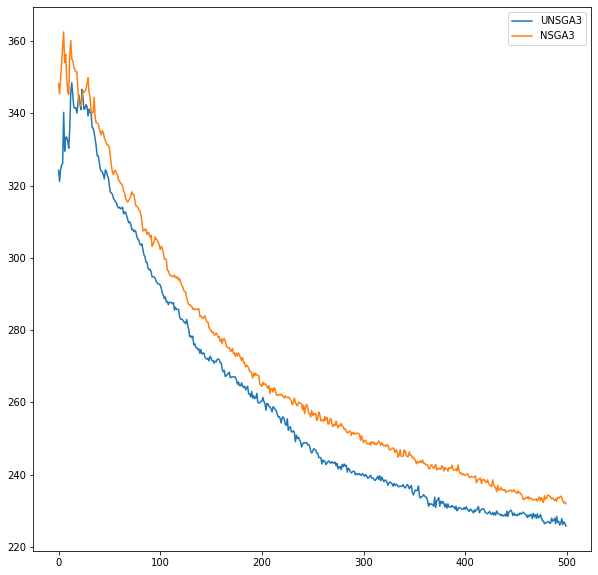

In [21]:
plt.figure(figsize=(10,10))
plt.plot(np.mean(unsgaiii["fuel_consumption"],axis=0),label="UNSGA3")
plt.plot(np.mean(nsgaiii["fuel_consumption"],axis=0),label="NSGA3")
# plt.plot(np.mean(unsgaiii_8_front_rand["fuel_consumption"],axis=0),label="UNSGA3-8")
# plt.plot(np.mean(unsgaiii_4_front["fuel_consumption"],axis=0),label="UNSGA3-4")
# plt.plot(np.mean(unsgaiii_4_front_2["fuel_consumption"],axis=0),label="UNSGA3-42")
plt.legend()
plt.show()

In [45]:
def getDriveTimesForRoutes(paths,timeMatrix,startNodes):
    routeTimes = []
    
    for path in paths:
        driveTimes = {}
        for start in startNodes:
            driveTimes[start] = 0
        
        
        for route in path:
            currentStart = route[0]
            #driveTimes[currentStart] = 0
            driveTime = 0
            for index in range(len(route)-1):
                driveTimes[currentStart]  += timeMatrix.iloc[route[index]][route[index+1]]/60
        
        for start in startNodes:
            if not start in driveTimes.keys():
                driveTimes[start] = 0
            
        
        routeTimes.append(driveTimes)
    return routeTimes


In [58]:
test = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in getDriveTimesForRoutes(unsgaiii["paths"],time_matrix_here,starts)])
meanTest1 = np.mean(test,axis=0)

test = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in getDriveTimesForRoutes(unsgaiii_2["paths"],time_matrix_here,starts)])
meanTest2 = np.mean(test,axis=0)

<BarContainer object of 7 artists>

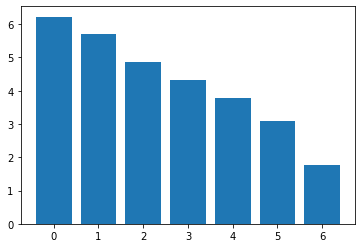

In [60]:
plt.bar(list(range(len(meanTest1))),meanTest1/60)

<BarContainer object of 7 artists>

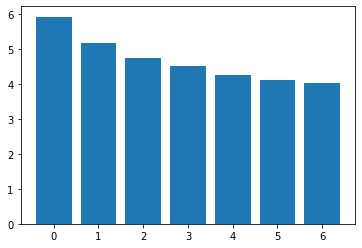

In [59]:
plt.bar(list(range(len(meanTest2))),meanTest2/60)

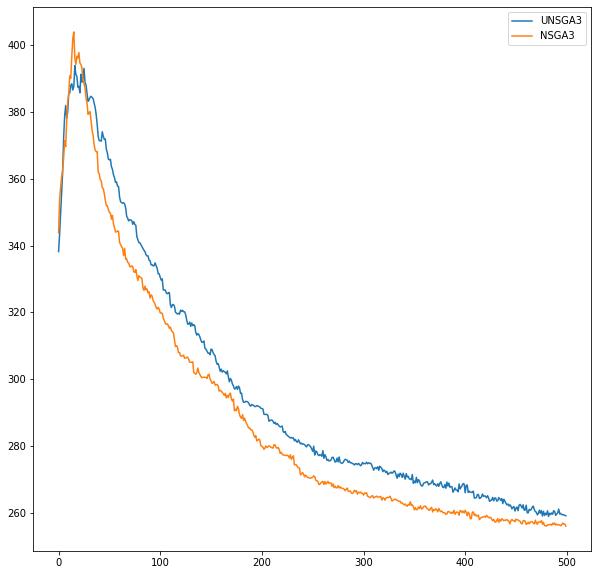

In [43]:
plt.figure(figsize=(10,10))
plt.plot(np.mean(unsgaiii_2["fuel_consumption"],axis=0),label="UNSGA3")
plt.plot(np.mean(nsgaiii_2["fuel_consumption"],axis=0),label="NSGA3")
# plt.plot(np.mean(unsgaiii_8_front_rand["fuel_consumption"],axis=0),label="UNSGA3-8")
# plt.plot(np.mean(unsgaiii_4_front["fuel_consumption"],axis=0),label="UNSGA3-4")
# plt.plot(np.mean(unsgaiii_4_front_2["fuel_consumption"],axis=0),label="UNSGA3-42")
plt.legend()
plt.show()

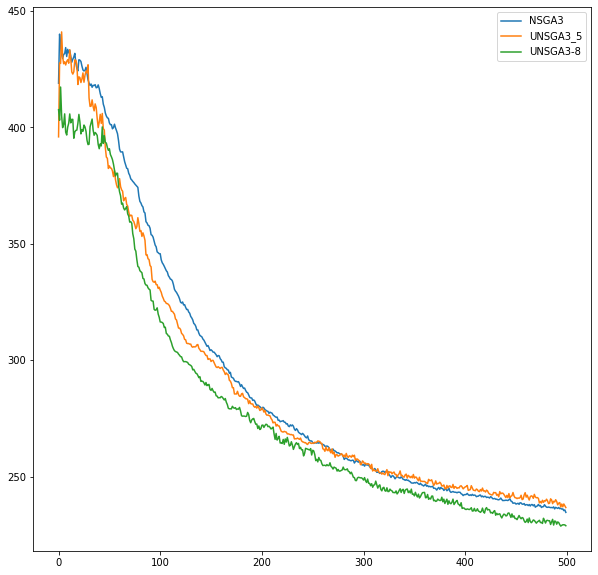

In [70]:
plt.figure(figsize=(10,10))
plt.plot(np.mean(nsga3_10.fuel_consumption.tolist(),axis=0),label="NSGA3")
#plt.plot(np.mean(unsgaiii_4_front_2["fuel_consumption"],axis=0),label="UNSGA3-4")
plt.plot(np.mean(unsgaiii_8_front_3["fuel_consumption"],axis=0),label="UNSGA3_5")
plt.plot(np.mean(unsgaiii_8_front_2["fuel_consumption"],axis=0),label="UNSGA3-8")
plt.legend()
plt.show()